In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

In [2]:
with open('numpy arrays/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)
    print('X loaded')
with open('numpy arrays/y.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)
    print('y loaded')

X loaded
y loaded


In [3]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

In [4]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [5]:
new_X = tf.image.resize(
    X, [100,100], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
new_X.shape
X = np.array(new_X)

In [6]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam 

In [7]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')

cbs = [cb_1,cb_2]

In [8]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y) 

In [9]:
model = Sequential()
# tf.keras.applications.InceptionResNetV2(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax', **kwargs
# )
conv_base = tf.keras.applications.InceptionV3(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax')) 

train_layers = [layer for layer in conv_base.layers[::-1][:5]]

for layer in conv_base.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [10]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 26,025,765
Trainable params: 25,983,141
Non-trainable params: 42,624
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1) 

Epoch 1/8
413/413 [==============================] - 681s 2s/step - loss: 527.3084 - accuracy: 0.5078 - val_loss: 26.8622 - val_accuracy: 0.7566
Epoch 2/8
413/413 [==============================] - 671s 2s/step - loss: 11.9289 - accuracy: 0.7778 - val_loss: 5.8045 - val_accuracy: 0.3220
Epoch 3/8
413/413 [==============================] - 635s 2s/step - loss: 3.5865 - accuracy: 0.8493 - val_loss: 2.4311 - val_accuracy: 0.7922
Epoch 4/8
413/413 [==============================] - 376s 909ms/step - loss: 2.4879 - accuracy: 0.9149 - val_loss: 5.0665 - val_accuracy: 0.2425
Epoch 5/8
413/413 [==============================] - 339s 821ms/step - loss: 1.0117 - accuracy: 0.9692 - val_loss: 0.7640 - val_accuracy: 0.9108
Epoch 6/8
413/413 [==============================] - 343s 831ms/step 

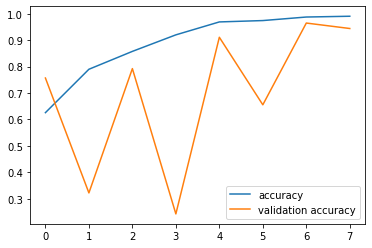

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()
plt.show()

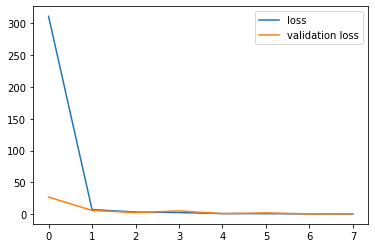

In [13]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()
plt.show()